In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [3]:
import time
from pathlib import Path
import glob
import os
import numpy as np
from tqdm import tqdm
import itertools
import csv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython.display as ipd
from IPython.display import clear_output
import math

import torch
import torchaudio
import soundfile as sf
from torchaudio.transforms import Vad

import wave
import librosa
import contextlib

import random
import shutil
from tqdm import tqdm
import subprocess
from pydub import AudioSegment
from scipy.io import wavfile

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="-", color='black')

In [5]:
from utils import *
from processing import *

## Audio utils

In [6]:
def plot_spec(filepath):
    samplingFrequency, signalData = wavfile.read(filepath)
    
    # Plot the signal read from wav file
    if len(signalData.shape) == 1:
        # single channel
        plt.figure(figsize=(12,8))
#         plt.grid(visible=True, axis='both')
        plt.subplot(211)

        plt.title('Spectrogram of a wav file')

        plt.plot(signalData)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.subplot(212)
        plt.specgram(signalData,Fs=samplingFrequency,NFFT=512)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
    else:
        signal_transpose = signalData.T
        for i, signal in enumerate(signal_transpose):
            print(f"Channel {i + 1}")
            plt.figure()
            plt.subplot(211)
            plt.title('Spectrogram of a wav file')

            plt.plot(signal.T)
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')

            plt.subplot(212)
            plt.specgram(signal.T,Fs=samplingFrequency,NFFT=512)
            plt.xlabel('Time')
            plt.ylabel('Frequency')

    plt.show()
    
def plot_duo(path1, path2):
    samplingFrequency1, signalData1 = wavfile.read(path1)
    samplingFrequency2, signalData2 = wavfile.read(path2)
    # single channel
#     plt.figure(figsize=(20,8))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4))
    axs[0, 0].plot(signalData1)
    axs[0, 0].set_title('Ref')
    axs[0, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[0, 1].specgram(signalData1,Fs=samplingFrequency1,NFFT=512)
    axs[0, 1].set(xlabel='Time', ylabel='Frequency')
    

    axs[1, 0].plot(signalData2)
    axs[1, 0].set_title('Com')
    axs[1, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[1, 1].specgram(signalData2,Fs=samplingFrequency2,NFFT=512)
    axs[1, 1].set(xlabel='Time', ylabel='Frequency')
    
    plt.tight_layout()
    plt.show()

def get_duration_file(fn_audio):
    with contextlib.closing(wave.open(str(fn_audio),'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration

def get_audio_overview(fn_audio):
    ob =  sf.SoundFile(fn_audio)
    return ob.subtype, ob.samplerate, ob.channels


def get_amplitute_file(path):
    sr, data = wavfile.read(path)
#     bit_depth = int(get_infor_file(path)[0].split('_')[-1])
    bit_depth = 16
    db = 20 * np.log10(max(abs(data))/(2**(bit_depth - 1) - 1))
    return sr, min(data), max(data), db

def get_duration_folder(folder):
    total_length = 0
    for audio in glob.glob(f"{folder}/*.wav"):
        try:
            total_length += get_duration_file(audio)
        except:
            print("error in ",audio)
    return total_length

def get_size_file(fname):
    return Path(fname).stat().st_size

def get_size_folder(folder):
    return sum([float(get_size_file(f)) for f in glob.glob(f"{folder}/*")])

def get_audio_stats(filename):
    cmd = ['ffmpeg', '-i', filename, '-map', '0:a', '-af', 'astats', '-f', 'null', '-']
#     cmd = ['ffprobe', filename]
    out = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE).stderr
    output_lines = [line.strip() for line in out.decode('utf-8').split('\n')]
    return output_lines


In [7]:
def stream_and_plot_audio(path, plot=False):
    audio = ipd.Audio(path, autoplay=True) 
    ipd.display(audio)
    if plot:
        plot_spec(path)

def stream_and_plot_in_class(folder, plot=False, delay=0.5):
    audio_in_folder = glob.glob(f'{folder}/*.wav')
    for i, f in enumerate(audio_in_folder):
        path  = str(Path(f))
        print(f"[{i + 1}/{len(audio_in_folder)}] {path}", end=' ')

        stream_and_plot_audio(path, plot=plot)

        duration = librosa.get_duration(filename=path)

        time.sleep(duration + delay)
        
def stream_and_plot_in_root(root, plot=False, start_index=0):
    folders = Path(root).glob('*')
#     nfiles = [len(os.listdir(str(x))) for x in folders]
    
    for index, folder in enumerate(list(folders)[start_index:]):
        print('id:', index + start_index, folder.name)
        
        stream_and_plot_in_class(str(folder), plot=plot)
        time.sleep(1.0)
        clear_output(wait=True)
        
def compare2files(file1, file2, plot=False, stream=False):
    if plot:
        plot_duo(file1, file2)
        
    if stream:
        stream_and_plot_audio(file1, plot=False)
        duration = librosa.get_duration(filename=file1)
        time.sleep(duration + 0.5)

        stream_and_plot_audio(file2, plot=False)
        duration = librosa.get_duration(filename=file2)
        time.sleep(duration + 0.5)

In [10]:
import noisereduce as nr
# load data
def remove_noise(path):
    rate, data = wavfile.read(path)
    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate, n_fft=512, prop_decrease=0.99)
    filename = f"{path.replace('.wav', '')}_rm_noise.wav"
    wavfile.write(filename, rate, reduced_noise)
    return True

def change_volume(path=None, dB=6, overwrite=True):
    segment = AudioSegment.from_file(path)
    segment += dB
    if overwrite:
        path = path
    else:
        path = path.replace('.wav', '') + f'_{dB}' +'.wav'
    segment.export(path, format='wav')
    print(f'Export to {path}')

## Stream and visualize audio


#### File

In [ ]:
path = f"log_service/audio_v2/346165056/346165056-20220310-173805_20220310_103846_com_0.wav"
stream_and_plot_audio(path, plot=True)
# !ffprobe "dataset/spoof/2835449000/2835449000_23_zoneB_rm_noise.wav"

In [ ]:
com = f"log_service/audio/20220208_101958_com_vad_1.wav"

ref = f"log_service/audio/20220208_101947_ref_vad_0.wav"

compare2files(ref, com, plot=True, stream=True)

#### Class

In [ ]:
with open("dataset/test_callbot_raw/infor.csv", 'w') as wf:
    for i, folder in enumerate(Path("dataset/test_callbot_raw/namdp5/").glob('*')):
#         wf.write(f"{i},{folder.name},{len(os.listdir(str(folder)))}\n")
        pass

In [ ]:
stream_and_plot_in_class("log_service/audio_v2/912582757/", plot=False)

#### Root

In [ ]:
stream_and_plot_in_root("dataset/test_callbot_raw/namdp5/", start_index=-2)

#### stats of audio

In [ ]:
!ffmpeg -i "dataset/test_callbot_raw/namdp5/349238241/349238241-20220204-101127-in_1.wav" -map 0:a -af astats -f null -

## Perform vad on long file(>10s of duration)

In [ ]:
path = f"log_service/audio/20220208_101947_ref.wav"
write = False
segments = vad_tool.VAD(win_length=300, frame_duration=30).detect(path, write=write, show=True)
print(len(segments))

# Visualize by graph dataset, plot graph

In [ ]:
origin = "dataset/train"
filenames = glob.glob(f"{origin}/*")

### number of files

In [ ]:
# so luong files moi nguoi
no_of_files = []
for f in tqdm(filenames):
    if len(os.listdir(f)) == 0:
        print(f)
    no_of_files.append(len(os.listdir(f)))
plt.figure(figsize=(24, 8))
plt.bar(filenames, no_of_files), plt.ylabel('number of files'), plt.xticks([])
plt.tight_layout()

In [ ]:
filenames[np.argmax(no_of_files)], filenames[np.argmin(no_of_files)], sum(no_of_files), max(no_of_files), min(no_of_files)

### Duration

In [ ]:
# duration
durations = []
for fn in tqdm(filenames):
    length = get_duration_folder(fn)
    durations.append(length)
plt.figure(figsize=(24, 8))
plt.bar(filenames, durations), plt.ylabel('durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
np.mean(durations), np.argmax(durations), sum(durations), max(durations), min(durations)

### average duration 

In [ ]:
# mat do thoi gian / 1 audio tren moi nguoi
import numpy as np
no_of_files = np.array(no_of_files)
durations = np.array(durations)
avg_durations = np.divide(durations, no_of_files)
plt.figure(figsize=(24, 8))
plt.bar(filenames, avg_durations), plt.ylabel('avg_durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
avg_durations.mean(), np.argmax(avg_durations), max(avg_durations), min(avg_durations)

In [ ]:
len(avg_durations[(avg_durations >= 1.5).nonzero()])

In [ ]:
#  index: 0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', 
#         4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', 
#         8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', 
#         12'Crest factor', 13'Flat factor', 14'Peak count',
#         15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', 
#         18'Zero crossings', 19'Zero crossings rate', 20'Error rate',

audio_full_infor = {}
detail_dir = Path('dataset/train_callbot/details/')
csv_s = detail_dir.glob('*.csv')

for f in tqdm(csv_s):
    audio_full_infor[f.name.replace('.csv', '')] = []
    
    with open(f, 'r', newline='') as rf:
        spamreader = csv.reader(rf, delimiter=',')
        next(spamreader, None)
        for row in spamreader:
            row_n = []
            for e in row:
                try:
                    row_n.append(float(e.strip()))
                except:
                    pass
            audio_full_infor[f.name.replace('.csv', '')].append(np.asanyarray(row_n))
            
    audio_full_infor[f.name.replace('.csv', '')] = np.asanyarray(audio_full_infor[f.name.replace('.csv', '')])
            
list(audio_full_infor.items())[:10]

index: <br/>
0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', <br/>
4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', <br/>
8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', <br/>
12'Crest factor', 13'Flat factor', 14'Peak count', <br/>
15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', <br/>
18'Zero crossings', 19'Zero crossings rate', 20'Error rate', <br/>

In [ ]:
# sum up informations
categories = ['Avg_duration', 'Min_duration', 'Max_duration', 
              'Avg_peakdB', 'Min_peakdB', 'Max_peakdB',
              'Avg_noisedB', 'Min_noisedB', 'Max_noisedB',
              '#valid files', '%valid']

# writefile = 'dataset/details_callbot.csv'
with open(writefile, 'w', newline='') as wf:
    spamwriter = csv.writer(wf, delimiter=',')
    spamwriter.writerow(categories)
    
    for k, v in tqdm(audio_full_infor.items()):
        avg_dur, min_dur, max_dur = np.mean(v[:,0]), min(v[:,0]), max(v[:,0])
        avg_db, min_db, max_db = np.mean(v[:,8]), min(v[:,8]), max(v[:,8])
        avg_noisedb, min_noisedb, max_noisedb =  np.mean(v[:,15]), min(v[:,15]), max(v[:,15])
        # error rate add here#
        f_invalid = read_blacklist(id=k,
                                 duration_limit=1.0, 
                                 dB_limit=-16, 
                                 error_limit=0, 
                                 noise_limit=-10, 
                                 details_dir="dataset/train_callbot/details/" )
        n_valid = len(v) - len(f_invalid) if f_invalid else len(v)
        p_valid = n_valid / len(v)
        
        row =  [avg_dur, min_dur, max_dur,
               avg_db, min_db, max_db,
               avg_noisedb, min_noisedb, max_noisedb,
               n_valid, p_valid]
#         spamwriter.writerow(row)

## Filtering DATASET

Check the inequality of dataset and print out details, return number of files greater ans lower than threshold(35 files)

In [ ]:
with open("Imposter_v2.txt", 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]

invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
# len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])

invalid_details = {}
for line in tqdm(lines):
    if ':' in line:
        k = ''.join(line.split(':')[1:]).strip()
        if k not in invalid_details:
            invalid_details[k] = {}
    elif '.wav' in line:
        fp = ''.join(line.split(' - ')[1:]).strip()
        n = line.split('-')[0].strip().replace('[', '').replace(']', '').split('/')
        rate = float(n[0])/float(n[1])
        
        k = list(invalid_details.keys())[-1]
        
        invalid_details[k][fp] = rate

list(invalid_details.items())[:10]
# invalid_cla                                                                                                                                     ss

### Train val generate simulation

In [ ]:
def generate_lists(raw_dataset, details_dir, num_spks, split_ratio,
                   duration_limit=1.0,
                   dB_limit=-10,
                   error_limit=0.5,
                   noise_limit=-16, 
                   lower_num=10, upper_num = 40,
                  gen_files=False):
    """
    Generate train test lists for zalo data
    """
    valid_spks = []
    invalid_spks = []
    
    root = Path(raw_dataset)
    classpaths = [d for d in root.iterdir() if d.is_dir()]
    classpaths.sort()
    
    if 0 < num_spks < len(classpaths) + 1:
        classpaths = classpaths[:num_spks]
    elif num_spks == -1:
        pass
    else:
        raise "Invalid number of speakers"

    print('Generate dataset metadata files, total:', len(classpaths))
    
    train_filepaths_list = []
    val_filepaths_list = []
    
    if gen_files:
        train_writer = open(Path(root.parent, 'train_dump.txt'), 'w')
        val_writer = open(Path(root.parent, 'val_dump_v3.txt'), 'w')    
        
    for classpath in tqdm(list(classpaths)[:], desc="Processing:..."):
        filepaths = list(classpath.glob('*.wav'))
        # filtering dataset
        ## check duration, volumn
        blist = read_blacklist(str(Path(classpath).name), 
                               duration_limit=duration_limit, 
                               dB_limit=dB_limit, 
                               error_limit=error_limit, 
                               noise_limit=noise_limit,
                               details_dir=details_dir)

        if blist is not None:
            filepaths = list(set(filepaths).difference(set(blist)))

        ## check duration, sr
        filepaths = check_valid_audio(filepaths, 1.0, 8000)

        ## checknumber of files
        if lower_num:
            if len(filepaths) < lower_num:
                continue
                
        if upper_num:
            if len(filepaths) >= upper_num:
                filepaths = filepaths[:upper_num]
                
        if len(filepaths) == 0:
            continue
                    
        valid_spks.append(Path(classpath).name)
        
        random.shuffle(filepaths)
        
        
        # val
        val_num = 3  # 3 utterances per speaker for val

        if split_ratio > 0:
            val_num = int(split_ratio * len(filepaths))

        val_filepaths = random.sample(filepaths, val_num)
        
        train_filepaths = filepaths if split_ratio == -1 else list(set(filepaths) - set(val_filepaths))
        
        # write train file
        if gen_files:
            for train_filepath in train_filepaths:
                label = str(train_filepath.parent.stem.split('-')[0])
                train_writer.write(label + ' ' + str(train_filepath) + '\n')

        val_filepaths_list.append(val_filepaths)
        train_filepaths_list.extend(train_filepaths)
        
    # gen val 
    val_pairs = []
    for val_filepaths in val_filepaths_list:
        for i in range(len(val_filepaths) - 1):
            for j in range(i + 1, len(val_filepaths)):
                label = '1'
                positive_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths[j]) + '\n'
                val_pairs.append(positive_pair)
    
                label = '0'
                while True:
                    x = random.randint(0, len(val_filepaths_list) - 1)
                    if not val_filepaths_list[x]:
                        continue
                    if val_filepaths_list[x][0].parent.stem != val_filepaths[i].parent.stem:
                        break
                        
                y = random.randint(0, len(val_filepaths_list[x]) - 1)
                negative_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths_list[x][y]) + '\n'
                val_pairs.append(negative_pair)
                
                if gen_files:
                    val_writer.write(positive_pair)
                    val_writer.write(negative_pair)
                
    if gen_files:
        val_writer.close()
        train_writer.close()
        

    print("Valid speakers:", len(valid_spks))
    print("Valid audio files:", len(train_filepaths_list))
    print("Validation pairs:", len(val_pairs))

    return valid_spks, invalid_spks

In [ ]:
valid_spks, invalid_spks = generate_lists(raw_dataset='dataset/test_callbot_raw/namdp5/', 
                                          details_dir='dataset/details/test_cb_raw/', 
                                          num_spks=-1, split_ratio=1.0, 
                                          duration_limit=1.0,
                                          dB_limit=-20,
                                          error_limit=0.5,
                                          noise_limit=-0,
                                          lower_num=None, upper_num = None,
                                          gen_files = False)

#### Write public and private test

In [ ]:
source  = 'dataset/test_callbot/private'
details_dir='dataset/details/test_cb_private/'

# import itertools    
# def all_pairs(lst):
#     return list(itertools.combinations(lst, 2))

# folders = Path(source).glob('*/')
# data = []
# for folder in folders:
#     f_lst = folder.glob('*.wav')
#     b_lst = read_blacklist(str(folder.name), 
#                            duration_limit=1.0, 
#                            dB_limit=-10, 
#                            error_limit=0.5, 
#                            noise_limit=-16,
#                            details_dir=details_dir)
#     if b_lst:
#         audio_lst = list(set(f_lst).difference(set(b_lst)))
#     else:
#         audio_lst = f_lst
#     data.extend([f"{folder.name} {path}" for path in audio_lst])

# pairs = all_pairs(data)
# lines_truth = []
lines_test = []

with open("dataset/test_callbot/valid_speaker/private_test_cb_truth.txt", 'r') as rf:
    pairs = [x.replace('\n', '') for x in rf.readlines()]

for pair in pairs:
    lable, path1, path2 = pair.split(' ')
    lines_test.append(f"{path1},{path2}\n")
    

    
with open(Path('dataset/test_callbot/valid_speaker/', 'private_test_cb.txt'), 'w') as wf:
    wf.write(f"audio_1,audio_2\n")
    wf.writelines(lines_test)
print("Done")

In [ ]:
with open("dataset/test_callbot/valid_speaker/private_test_cb_truth.txt", 'r') as rf:
    pairs = [x.replace('\n', '') for x in rf.readlines()]
len(pairs)

## Draft

#### Export test file from folder

In [ ]:
os.makedirs("log_service/ref_audio_v2/audio", exist_ok= True)
spk_dirs = Path('log_service/ref_audio_v2/wavs-2022-03-10/').glob('*')
for spk in spk_dirs:
    os.makedirs('log_service/ref_audio_v2/audio/' + str(spk).split('/')[-1], exist_ok=True)
    for audio in glob.glob(f"{spk}/*.wav"):
#         print(audio, str('/'.join(audio.split('/')[:2]+['audio']+[audio.split('/')[-2], 'com_'+ audio.split('/')[-1]])))
        os.rename(audio, str('/'.join(audio.split('/')[:2]+['audio']+[audio.split('/')[-2], 'com_' + audio.split('/')[-1]])))
#         print(audio)    
        pass

In [48]:
import itertools
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

ref_case = ['norm', 'auth','all', 'none']
com_case = ['norm', 'auth','all', 'none']
a =[(x,y) for x in ref_case for y in com_case]

for case in tqdm(a):
    if case[0] == 'all':
        ref_set = '*'
    if case[1] == 'all':
        com_set = '*'
    if case[0] == 'none':
        ref_set = ''
    if case[1] == 'none':
        com_set = ''
    if case[0] in ['norm', 'auth']:
        ref_set = case[0] + '_ref'
        
    if case[1] in ['norm', 'auth']:
        com_set = case[1] + '_com'
    
    list_test_ref = glob.glob(f'log_service/audio_bu/ref_bu/{ref_set}/*/*.wav')
    list_test_com = glob.glob(f'log_service/audio_bu/wavs-2022-03-16/{com_set}/*/*.wav')

    list_test = list(set(list_test_ref+list_test_com))
    pairs = all_pairs(list_test)

    lines = []
    lines_truth = []
    counts_label = [0, 0]
    for pair in pairs:
        label1 = os.path.split(pair[0])[-1].split('.')[0].split('-')[0].replace('com_', '')
        label2 = os.path.split(pair[1])[-1].split('.')[0].split('-')[0].replace('com_', '')

        lines_truth.append(f"{int(label2==label1)} {pair[0]} {pair[1]}\n")    
        lines.append(f"{pair[0]},{pair[1]}\n")

        counts_label[0] += int(label2!=label1)
        counts_label[1] += int(label2==label1)

    with open(f'log_service/audio_bu/{case[0]}_{case[1]}_truth.txt' , 'w') as wf:
        wf.writelines(lines_truth)
    with open(f'log_service/audio_bu/{case[0]}_{case[1]}.txt' , 'w') as wf:
        wf.write("audio1,audio2\n")
        wf.writelines(lines)

print('Done')
#     counts_label

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

Done


In [26]:
list_test = glob.glob('log_service/audio_bu/wavs-2022-03-16/*/*.wav')
os.makedirs('log_service/audio_bu/wavs-2022-03-16/norm/', exist_ok=True)
os.makedirs('log_service/audio_bu/wavs-2022-03-16/auth/', exist_ok=True)

for fname in tqdm(list_test):
    if 'norm' in fname:
        os.makedirs(str(Path(fname).parent).replace('log_service/audio_bu/wavs-2022-03-16/', 'log_service/audio_bu/wavs-2022-03-16/norm/'), exist_ok=True)
        subprocess.call(f"mv {fname} {fname.replace('log_service/audio_bu/wavs-2022-03-16/', 'log_service/audio_bu/wavs-2022-03-16/norm/')}", shell=True)
    else:
        os.makedirs(str(Path(fname).parent).replace('log_service/audio_bu/wavs-2022-03-16/', 'log_service/audio_bu/wavs-2022-03-16/auth/'), exist_ok=True)
        subprocess.call(f"mv {fname} {fname.replace('log_service/audio_bu/wavs-2022-03-16/', 'log_service/audio_bu/wavs-2022-03-16/auth/')}", shell=True)

100%|██████████| 374/374 [00:11<00:00, 32.74it/s]


In [ ]:
count_1 = 0
for di in glob.glob('log_service/ref_audio_v2/audio/*'):
    list_test = glob.glob(f"{di}/*.wav")
    pairs = all_pairs(list_test)
    count_1 += len(pairs)
count_1

In [24]:
str(Path(list_test[0]).parent).replace('log_service/audio_bu/wavs-2022-03-16/', 'log_service/audio_bu/wavs-2022-03-16/norm/')

'log_service/audio_bu/wavs-2022-03-16/norm/346165056'

In [ ]:
list_test = glob.glob('log_service/ref_audio_v2/audio/*/*.wav')
print(list_test[0].replace('com_', ''))

#### test augment types of audio

In [ ]:
default_path1 = 'dataset/dump/thuyth.wav'
stream_and_plot_audio('log_service/audio_v2/912582757/912582757-20220309-092406_20220309_022733_com_0.wav', True)

In [ ]:
with open('backup/Raw_ECAPA/result/private_test_results.txt', 'r') as rf:
    lines = [line.replace('\n', '') for line in rf.readlines()[1:]]

count = {}
for line in lines:
    audio1, audio2, pred, score = line.split(',')
    label1, fname1 = audio1.split('/')[-2:]
    label2, fname2 = audio2.split('/')[-2:]
    if (label1 == label2) != bool(int(pred)):
        if fname1 not in count:
            count[fname1] = 0
        if fname2 not in count:
            count[fname2] = 0
        
        if bool(int(pred)) and not (label1 == label2):
            # false accepted:
            print(f"FP {fname1} {fname2} {score}")
        else:
            # False negative pairs: false rejected
            print(f"FN {fname1} {fname2} {score}")
        count[fname1] += 1
        count[fname2] += 1
    pass
count

In [ ]:
sound = sf.read('dataset/dump/thuyth.wav')[0]

In [ ]:
from signal_process_utils import *
from utils import random_drop_chunk

In [ ]:
sound_dropped = random_drop_chunk(sound, [1], noise_factor=0)
plt.figure()
plt.plot(sound_dropped)

plt.figure()
plt.plot(sound)
plt.show()

np.testing.assert_allclose(sound_dropped, sound, rtol=1e-03, atol=1e-05)


In [ ]:
ipd.Audio(sound_dropped, rate=8000, autoplay=True)

In [159]:
from pydub import AudioSegment
from utils import *
for noise_f in tqdm(glob.glob("dataset/noise_vad/noise_vad/*/*.wav")):
    noise_seg = AudioSegment.from_file(noise_f)
    noise_seg_new_vol = gain_target_amplitude(noise_seg, -38)
    noise_seg_new_vol.export(noise_f, format="wav")

100%|██████████| 9015/9015 [00:05<00:00, 1798.86it/s]


In [14]:
from utils import *
from processing import audio_loader
augment_engine = audio_loader.AugmentWAV(musan_path="dataset/augment_data/musan_split/",
                                 rir_path="dataset/augment_data/RIRS_NOISES/simulated_rirs/",
                                 max_frames=500,
                                 sample_rate=8000)

noise music None


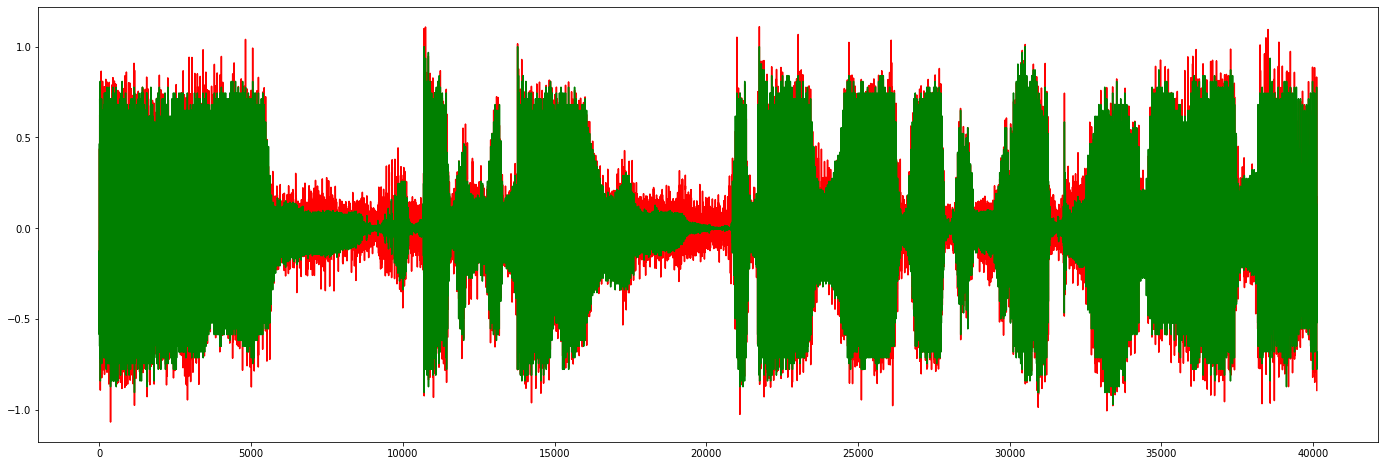

In [48]:
audio_file = "dataset/train_callbot_v2/train_v2/spk0/spk0-20220205-064325-in_0.wav"
audio = audio_loader.loadWAV(audio_file, 500, 
                evalmode=False, 
                augment=False, 
                sample_rate=8000, 
                augment_chain=['env_corrupt', 'time_domain', 'spec_domain'])
audio_raw = audio.copy()
augtype , mode, order = None, None, None
augtype = np.random.choice(['rev', 'noise', 'both', 'none'], p=[0, 1.0, 0, 0])

if augtype == 'rev':
    audio = augment_engine.reverberate(audio)
elif augtype == 'noise':
    mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'], p=[1.0, 0, 0, 0])
    audio = augment_engine.additive_noise(mode, audio)
elif augtype == 'both':
    # combined reverb and noise
    order = np.random.choice(['noise_first', 'rev_first'], p=[0.5, 0.5])
    if order == 'rev_first':
        audio =augment_engine.reverberate(audio)
        mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'], p=[0.3, 0.3, 0.4, 0])
        audio = augment_engine.additive_noise(mode, audio)
    else:
        mode = np.random.choice(['music', 'speech', 'noise', 'noise_vad'], p=[0.3, 0.3, 0.4, 0])
        audio = augment_engine.additive_noise(mode, audio)   
        audio = augment_engine.reverberate(audio)
else:
    # none type means dont augment
    pass

print(augtype , mode, order)

plt.figure(figsize=(24,8))
plt.plot(np.squeeze(audio), color='red')
plt.plot(np.squeeze(audio_raw), color='green')
plt.show()
ipd.Audio(audio, rate=8000, autoplay=True)